In [1]:
!pip install --upgrade flax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import jax.numpy as np
from jax import random, vmap, grad, jit
from jax.example_libraries import optimizers

import flax.linen as nn
import optax

import itertools
from functools import partial
from tqdm import trange
import numpy.random as npr
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

/usr/local/lib/python3.9/dist-packages/flax/core/frozen_dict.py:169: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(


In [3]:
class LSTM(nn.Module):
  hidden_dim: int
  out_dim: int

  @nn.compact
  def __call__(self, x):
    scan_fn = nn.scan(nn.LSTMCell,
                      variable_broadcast="params",
                      split_rngs={"params": False},
                      in_axes=1,
                      out_axes=1)
    
    carry, hidden = nn.LSTMCell.initialize_carry(random.PRNGKey(0), batch_dims=(len(x),), size=self.hidden_dim)
    (carry, hidden), x = scan_fn()((carry, hidden), x)

    # Output layer
    x = nn.Dense(self.out_dim)(hidden)
    return x

In [4]:
# batch_size = 64
# lags = 8
# in_dim = 4

# key_1, key_2, key_3 = random.split(random.PRNGKey(0), 3)

# inputs = random.uniform(key_1, (batch_size, lags, in_dim))
# model = LSTM(hidden_dim=32, out_dim=1)
# variables = model.init(key_3, inputs)
# outputs = model.apply(variables, inputs)
# print(inputs.shape)
# print(outputs.shape)
# print(len(inputs))

In [5]:
def create_lags(data, L):
    N = data.shape[0] - L
    D = data.shape[1]
    X = np.zeros((N, L, D))
    Y = np.zeros((N, D))
    for i in range(0,N):
        X = X.at[i,:,:].set(data[i:(i+L), :])
        Y = Y.at[i,:].set(data[i+L, :])
    return X, Y

In [6]:
class Seq2seq():
    def __init__(self, hidden_dim, batch, rng_key = random.PRNGKey(0)):
        # Initialization and evaluation functions
        inputs, targets = batch
        self.model = LSTM(hidden_dim, targets.shape[-1])
        self.params = self.model.init(rng_key, inputs)
        print(self.model.tabulate(rng_key, inputs))

        # Optimizer
        lr = optax.exponential_decay(1e-3, transition_steps=1000, decay_rate=0.9)
        self.optimizer = optax.adam(learning_rate=lr)
        self.opt_state = self.optimizer.init(self.params)

        # Logger to monitor the loss function
        self.loss_log = []
        self.itercount = itertools.count()

    @partial(jit, static_argnums=(0,))
    def loss(self, params, batch):
        inputs, targets = batch
        outputs = self.model.apply(params, inputs)
        loss = np.mean((targets - outputs)**2)
        return loss

    # Define a compiled update step
    @partial(jit, static_argnums=(0,))
    def step(self, params, opt_state, batch):
        grads = grad(self.loss)(params, batch)
        updates, opt_state = self.optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state


    # Optimize parameters in a loop
    def train(self, dataset, nIter = 10000):
        data = iter(dataset)
        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            batch = next(data)
            self.params, self.opt_state = self.step(self.params, self.opt_state, batch)
            # Logger
            if it % 100 == 0:
                loss = self.loss(self.params, batch)
                self.loss_log.append(loss)
                pbar.set_postfix({'loss': loss})

In [7]:
def f(t):
    f = np.sin(np.pi*t)
    return f

In [8]:
seq_len = 5
rng_key = random.PRNGKey(0)
noise = 0.0

t = np.arange(0,10,0.1)[:,None]
timeseries = f(t)
timeseries = timeseries + timeseries.std(0)*noise*random.normal(rng_key, timeseries.shape)

# Use 2/3 of all data as training Data
train_size = int(len(timeseries) * (2.0/3.0))
train_data = timeseries[0:train_size,:]

# Normalize
mean, std = train_data.mean(0), train_data.std(0)
train_data = (timeseries - mean)/std

# Create lags
X, Y = create_lags(train_data, seq_len)

In [9]:
from torch.utils import data

class DataGenerator(data.Dataset):
    def __init__(self, X, Y, batch_size=64, rng_key=random.PRNGKey(1234)):
        'Initialization'
        # X: (num_examples, seq_len, in_dim)
        # Y: (num_examples, out_dim)
        self.X = X
        self.Y = Y
        self.N = X.shape[0]
        self.batch_size = batch_size
        self.key = rng_key

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        inputs, targets = self.__data_generation(subkey)
        return inputs, targets

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        # encoder
        inputs = self.X[idx,...]
        targets = self.Y[idx,...]
        return inputs, targets

In [10]:
# Create data set
batch_size = 32
dataset = DataGenerator(X, Y, batch_size)

data = iter(dataset)
batch = next(data)
inputs, targets = batch
print(inputs.shape)
print(targets.shape)

(32, 5, 1)
(32, 1)


In [11]:
# Model creation
hidden_dim = 4
model = Seq2seq(hidden_dim, batch)


                                  LSTM Summary                                  
┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ path           ┃ module   ┃ inputs         ┃ outputs        ┃ params         ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│                │ LSTM     │ float32[32,5,… │ float32[32,1]  │ Dense_0:       │
│                │          │                │                │   bias:        │
│                │          │                │                │ float32[1]     │
│                │          │                │                │   kernel:      │
│                │          │                │                │ float32[4,1]   │
│                │          │                │                │ ScanLSTMCell_… │
│                │          │                │                │   hf:          │
│                │          │                │                │     bias:      │
│                │         

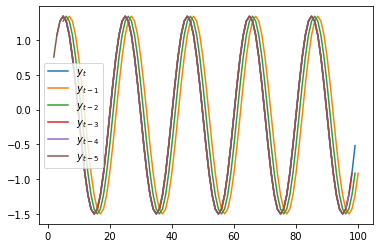

In [12]:
N = Y.shape[0]
plt.figure()
plt.plot(np.arange(seq_len, N+seq_len), Y, label = '$y_t$')
for i in range(seq_len):
  plt.plot(np.arange(seq_len-i+1, N+seq_len-i+1), X[:, seq_len-i+1,:], label = '$y_{t-%d}$' % (i+1))
plt.legend()

In [13]:
# Train
model.train(dataset, nIter=40000)

100%|██████████| 40000/40000 [01:16<00:00, 522.39it/s, loss=2.5234976e-07]


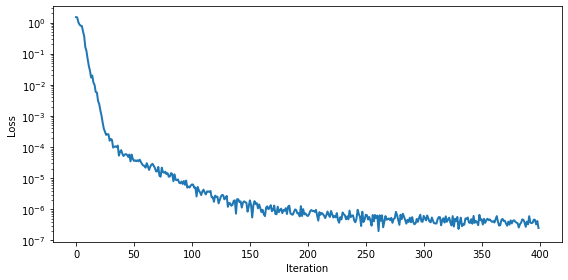

In [14]:
# Plot loss
plt.figure(figsize = (8,4))
plt.plot(model.loss_log, lw=2)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.tight_layout()

In [15]:
opt_params = model.params
pred_fn = jit(lambda x: model.model.apply(opt_params, x))
# One-step ahead prediction (normalized)
N, D = timeseries.shape
pred = np.zeros((N-seq_len, D))
X_tmp =  X[0:1,:,:]
for i in trange(N-seq_len):
    pred = pred.at[i:i+1].set(pred_fn(X_tmp))
    X_tmp = X_tmp.at[:,:-1,:].set(X_tmp[:,1:,:])
    X_tmp = X_tmp.at[:,-1,:].set(pred[i])

# De-normalize predictions
pred = pred*std + mean
error = np.linalg.norm(timeseries[seq_len:] - pred, 2)/np.linalg.norm(timeseries[seq_len:], 2)
print('\nRelative L2 prediction error: %e' % (error))

100%|██████████| 95/95 [00:01<00:00, 54.40it/s]



Relative L2 prediction error: 4.304776e-03


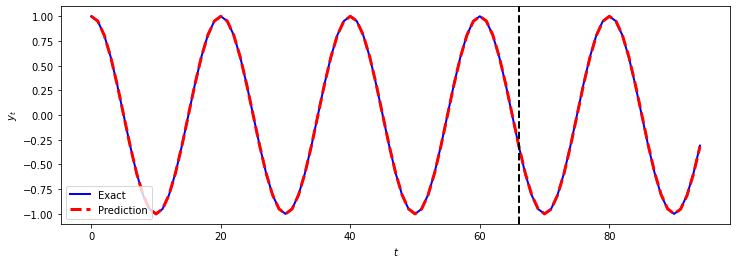

In [16]:
plt.figure(figsize=(12,4))
plt.plot(timeseries[seq_len:], 'b-', linewidth = 2, label = "Exact")
plt.plot(pred, 'r--', linewidth = 3, label = "Prediction")
plt.axvline(train_size, c='k', ls='--', lw=2)
plt.axis('tight')
plt.xlabel('$t$')
plt.ylabel('$y_t$')
plt.legend(loc='lower left')